# Clustering con DBSCAN en Spark

In [1]:
# Carga de librerías
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from scipy.spatial import distance
import pyspark.sql.functions as sql_f
from pyspark.sql.functions import col, substring
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import substring
from pyspark.sql.functions import size, col
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Row
from itertools import combinations

# Variable de entorno. Modificar en caso de disponer de varias
# versiones de Java instaladas.
os.environ["JAVA_HOME"] = r"/home/cristhian/Descargas/OpenJDK8U-jdk_x64_linux_hotspot_8u452b09/jdk8u452-b09"

In [2]:
# Definición del entorno de ejecución
CORES = 12 # Número de núcleos de CPU a usar
PARTS = 12 # Número de particiones del dataset (para hacer repartition)
FRAC = 0.5 # Fracción de los datos aleatoriamente seleccionados
DIMS = 14  # Número de componentes PCA seleccionadas en base a mayor varianza explicada

spark = (
    SparkSession.builder.master(f"local[{CORES}]")
    .appName(f"Local DT con {CORES} particiones")
    .config("spark.driver.memory", "24g")
    .config("spark.executor.memory", "24g")
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")

    .getOrCreate()
)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoints")

:: loading settings :: url = jar:file:/home/cristhian/anaconda3/envs/Spark_DBSCAN/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/cristhian/.ivy2/cache
The jars for the packages stored in: /home/cristhian/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f4845029-43e0-4b02-83fe-e4b7c8bf8245;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 157ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------

# Contexto

Spotify es una plataforma de música que contiene millones de canciones de todo tipo. Gracias a su API, podemos acceder a multitud de atributos de cada canción, como danceability, energy, valence, tempo, loudness, acousticness o instrumentalness. A partir de dichas características surgen preguntas interesantes: ¿cómo se distribuyen las canciones según estas propiedades? ¿Canciones del mismo género comparten valores similares? ¿Existen subgéneros bien diferenciados? ¿Hay canciones que se comportan como anomalías?

Para abordar estas cuestiones, aplicaremos técnicas de aprendizaje no supervisado que permitan estructurar el espacio de datos. En concreto, utilizaremos DBSCAN, un algoritmo de clustering capaz de detectar agrupaciones naturales sin necesidad de definir el número de clusters y que es robusto frente a ruido. Esto lo hace ideal para descubrir grupos de canciones similares sin asumir categorías previas. Sin embargo, su complejidad O(n²) limita su aplicabilidad directa en grandes volúmenes de datos, por lo que implementaremos una versión escalable sobre Apache Spark.

# Objetivos

El objetivo principal de este proyecto es desarrollar, analizar y evaluar una versión escalable del algoritmo DBSCAN aplicada a un conjunto de datos musicales extraído de Spotify. Este análisis nos permitirá explorar la estructura interna del espacio de canciones en función de sus características acústicas, así como detectar agrupaciones o canciones atípicas.

En particular, nos proponemos: 

* Analizar y preprocesar nuestros datos para su uso por DBSCAN.

* Implementar DBSCAN en Spark para aprovechar el paralelismo.

* Utilizar el algoritmo para identificar grupos de canciones similares

* Evaluar su escalabilidad mediante métricas como scale-up, size-up y speed-up. 

# Análisis Exploratorio de Datos

El Análisis Exploratorio de Datos (EDA), es una fase esencial en el proceso de la ciencia de datos ya que nos ayuda a familiarizarnos con el conjunto de datos y nos guía en el proceso de construcción del modelo. A continuación se llevará a cabo un análisis sencillo de las características básicas de nuestros datos. 

El análisis ha sido llevado a cabo usando `sklearn` junto con `matplotlib` y `seaborn` para la visualización. En este trabajo se ha optado por no llevar a cabo una aproximación distribuida para el EDA por varias razones. 
- En primer lugar, nuestro conjunto de datos es lo suficientemente pequeño como para que el análisis de los datos en un único dispositivo sea no demasiado costoso, por lo tanto, hacer un EDA en distribuido podría ser incluso más costoso debido a la sobrecarga de Spark. 
- En segundo lugar, las operaciones llevadas a cabo en un EDA son por lo general operaciones sencillas con complejidad lineal como el cálculo de medias y varianzas. Estas operaciones no son tan costosas como el uso de algoritmos de aprendizaje con órdenes de complejidad mayores, donde los tiempos de ejecución escalan mucho más rápido con el número de datos requiriendo de cómputo distribuido.

### Tamaño y distribución de variables del dataset

El dataset contiene 32.833 canciones y 23 columnas, con información sobre pistas, artistas, álbumes y playlists, además de características musicales como popularidad, energía, tempo o valencia. Las variables se dividen en 10 categóricas y 13 numéricas, siendo estas últimas clave para el análisis musical.

Las variables numéricas presentan distribuciones variadas: encontramos algunas aproximadamente normales (como duration) o normales con skewness (energy o danceability), otras con kurtosis (valence) y otras con distribución logarítmica (liveness o acousticness).

Otra observación es que las variables no tienen la misma escala, lo cual es un requisito fundamental para que DBSCAN funcione correctamente. Por tanto, tendremos que realizar una estandarización en el preprocesamiento de datos.

In [3]:
# Carga de datos
data = pd.read_csv("spotify_songs.csv")

print("Tamaño: ", data.shape)
print(data.head())

Tamaño:  (32833, 23)
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Just

In [4]:
print("Variables y sus tipos")
print(data.info())

Variables y sus tipos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-nul

In [5]:
print("Variables categóricas:")
data_cat = data.select_dtypes(include = ['object'])
print(data_cat.columns)

Variables categóricas:
Index(['track_id', 'track_name', 'track_artist', 'track_album_id',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_id', 'playlist_genre', 'playlist_subgenre'],
      dtype='object')


In [6]:
print("Resumen estadístico:")
print(data.describe())

Resumen estadístico:
       track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.171000      0.0000

Distribución variables numéricas:


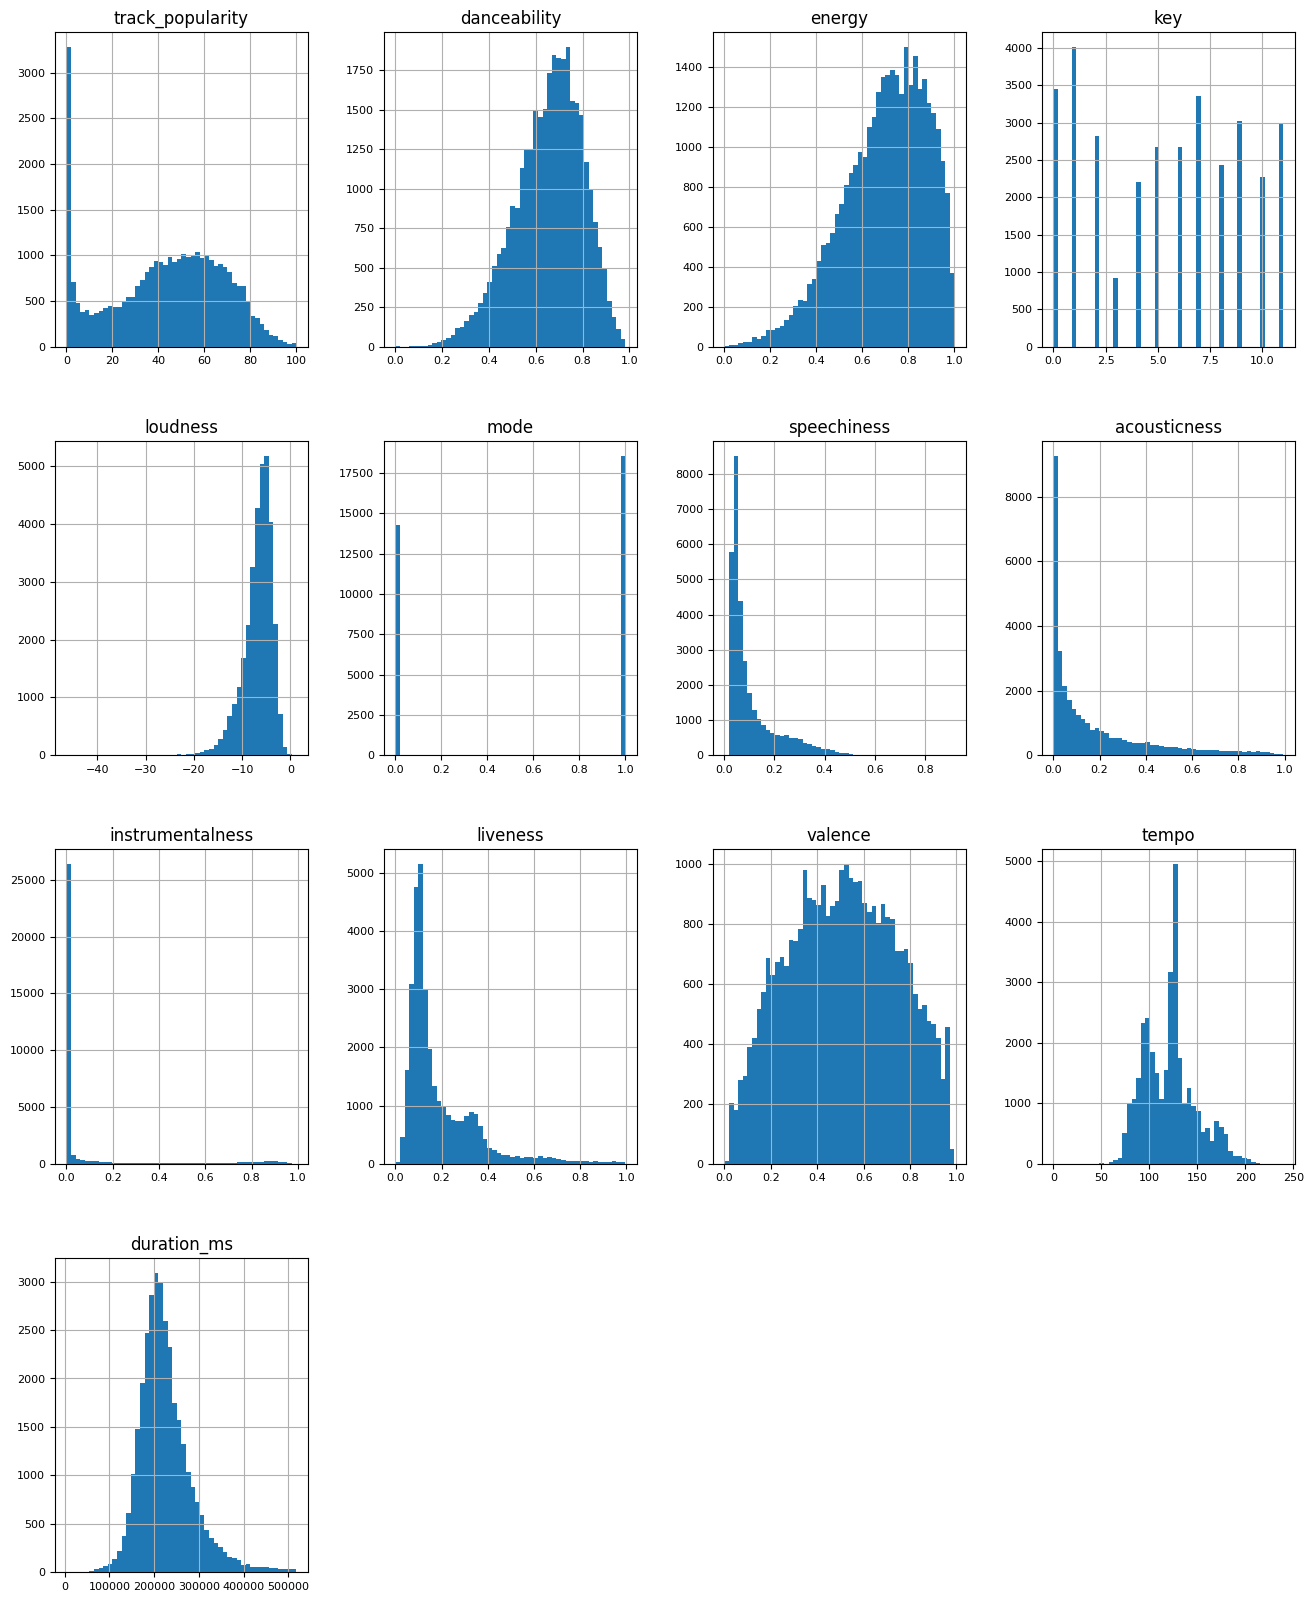

In [7]:
print("Distribución variables numéricas:")
data_num = data.select_dtypes(include = ['int64', 'float64'])
data_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

### Detección de valores nulos

Existen algunos valores nulos para algunas de las variables de tipo string (concretamente, encontramos 5 missing values en 3 columnas string). Esto se produce probablemente por la inclusión de ciertas canciones con valores omitidos para el nombre de una canción, artista o álbum. Como probablemente no usaremos esas columnas en el futuro, no nos resulta preocupante.

In [8]:
print("Número de valores nulos:")
print(data.isnull().sum())

Número de valores nulos:
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


### Distribución de géneros y subgéneros

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0), (0.9019607843137255, 0.3333333333333333, 0.050980392156862744, 1.0), (0.19215686274509805, 0.6392156862745098, 0.32941176470588235, 1.0), (0.4588235294117647, 0.4196078431372549, 0.6941176470588235, 1.0), (0.38823529411764707, 0.38823529411764707, 0.38823529411764707, 1.0), (0.4823529411764706, 0.2549019607843137, 0.45098039215686275, 1.0)]


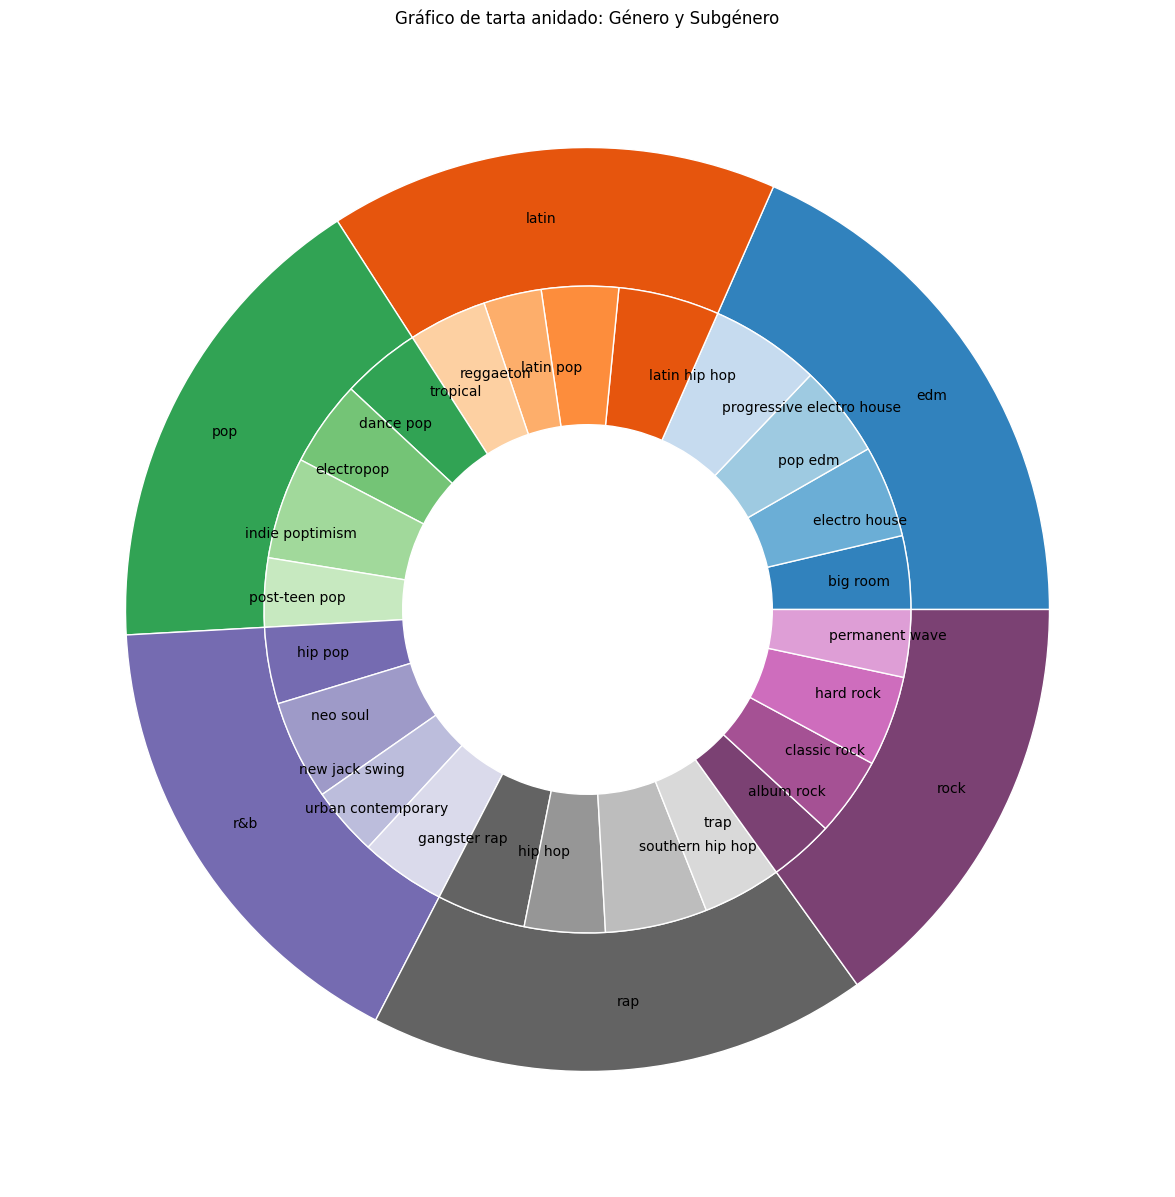

In [9]:
# 1. Agrupar por 'playlist_genre' para la capa externa y contar la cantidad de registros por género.
outer_data = data.groupby('playlist_genre').size()

# 2. Agrupar por ambas variables para la capa interna y contar la cantidad de registros por cada combinación de género y subgénero.
inner_data = data.groupby(['playlist_genre', 'playlist_subgenre']).size()

# Preparar los datos para el gráfico:
# Etiquetas y tamaños para la tarta externa (por géneros)
outer_labels = outer_data.index.tolist()
outer_sizes = outer_data.values.tolist()

# Para la tarta interna (por subgéneros) se requiere mantener el orden para asignar colores coherentes.
inner_labels = []
inner_sizes = []
# Definiremos una lista de colores para la tarta interna basados en un colormap.
colors_inner = []

# Usamos un colormap de matplotlib  para obtener colores diferenciados.
cmap = plt.get_cmap('tab20c')
cmap2 = plt.get_cmap('tab20b')
# Para la asignación de colores, definimos un índice que se irá incrementando a medida que agregamos subcategorías.
color_idx = 0

# Recorremos cada género para extraer sus subgéneros
for genre in outer_labels:
    # Seleccionar los datos del género actual
    sub_data = inner_data[genre]
    # Agregar las etiquetas de subgénero y sus cantidades
    for subgenre, count in sub_data.items():
        inner_labels.append(subgenre)
        inner_sizes.append(count)
        # Asignar un color del colormap (se puede ajustar la estrategia de asignación si se desea)
        if (color_idx < 20):
            colors_inner.append(cmap(color_idx))
        else:
            colors_inner.append(cmap2(color_idx-4))
        color_idx += 1
# Crear el gráfico
fig, ax = plt.subplots(figsize=(15, 15))

colors_outer = [cmap(i*4) for i in range(5)]
colors_outer.append(colors_inner[-4])
print(colors_outer)
# Capa externa: gráfico de tarta de géneros.
# Usamos 'wedgeprops' para definir el ancho de las "donut slices".
ax.pie(outer_sizes, radius=1, labels=outer_labels, labeldistance=0.85,
       colors=colors_outer, wedgeprops=dict(width=0.3, edgecolor='white'))

# Capa interna: gráfico de tarta de subgéneros.
# Se dibuja sobre la capa externa.
ax.pie(inner_sizes, radius=1-0.3, labels=inner_labels, labeldistance=0.75,
       colors=colors_inner, wedgeprops=dict(width=0.3, edgecolor='white'))

# Asegurar que el gráfico tiene relación de aspecto 1:1 para que sea circular.
ax.set(aspect="equal")
plt.title("Gráfico de tarta anidado: Género y Subgénero")
plt.show()

En la figura superior podemos ver un gráfico de tarta anidado, donde la capa externa muestra la frecuencia de los gêneros, mientras que la capa interna muestra la frecuencia de los subgêneros. Como podemos ver, la distribución de géneros y subgéneros es bastante uniforme ya que tenemos 6 géneros con aproximadamente la misma cantidad de canciones (5000-6000) y 4 subgéneros para cada género que también son representativos (1000-2000 canciones). 

El género más común es el edm con 6043 canciones mientras que el menos común es el rock con 4951 canciones.

En cuanto a los subgéneros, el más común es progressive electro house con 1809 canciones, mientras que el menos común es el reggaeton con 949 canciones.

### Análisis de correlación

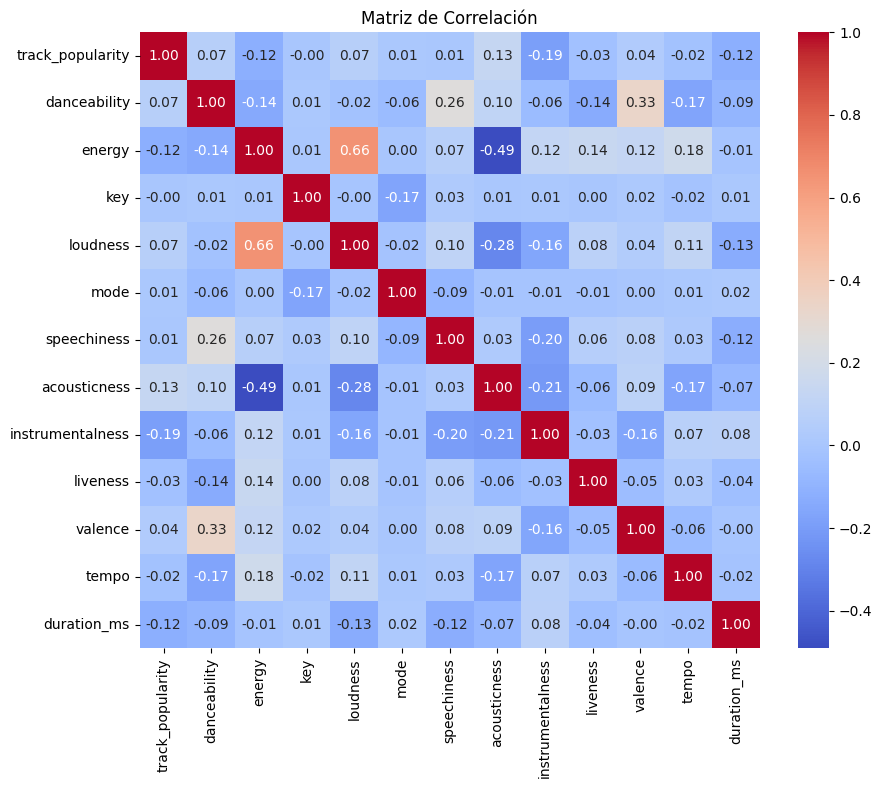

In [10]:
# Spearman
corr_matrix = data_num.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

En el gráfico superior vemos los coeficientes de correlación de las variables por pares. Este gráfico nos informa de correlaciones notables, como la relación negativa entre `energy` y `acousticness` o la relación positiva entre `energy` y `loudness`. Sin embargo, por lo general las variables están poco correladas, por lo que no es posible la eliminación de variables por alta correlación. Además, esto nos hace intuir que la aplicación de técnicas de reducción de la dimensionalidad como PCA probablemente no sea tan efectiva. 

### Gráficos de popularidad

A continuación se muestran algunos gráficos en relación a la variable `popularidad`, que tiene especial interés en nuestro conjunto de datos para el análisis de tendencias y gustos musicales de la población.
Los gráficos que se muestran son los siguientes:
- Artistas con mayor popularidad media
- Albumes con mayor popularidad media
- Géneros con mayor popularidad media
- Subgéneros con mayor popularidad media



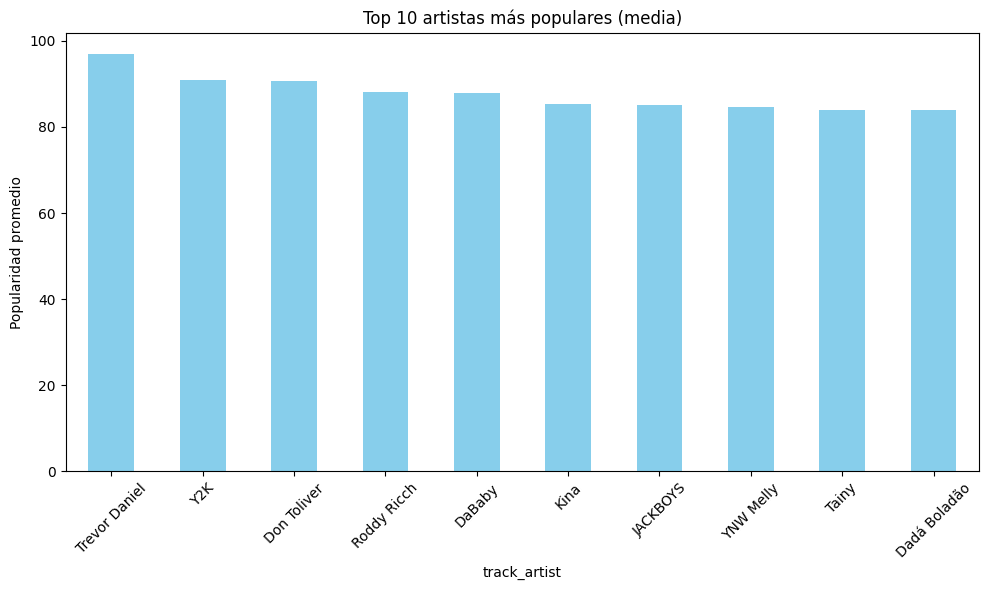

In [11]:
top_artistas = data.groupby('track_artist')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_artistas.plot(kind='bar', color='skyblue')
plt.title('Top 10 artistas más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

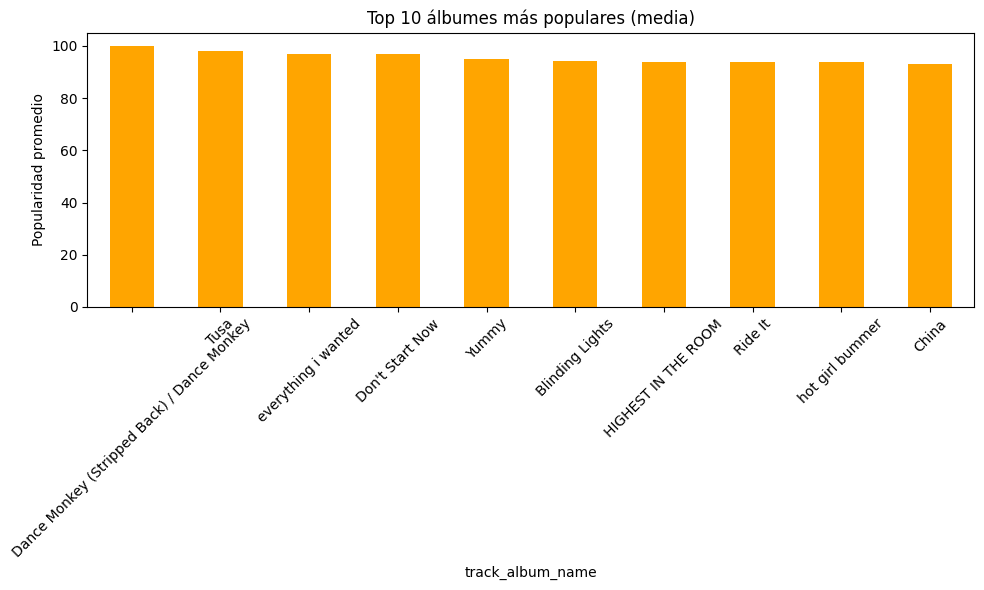

In [12]:
top_albums = data.groupby('track_album_name')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_albums.plot(kind='bar', color='orange')
plt.title('Top 10 álbumes más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


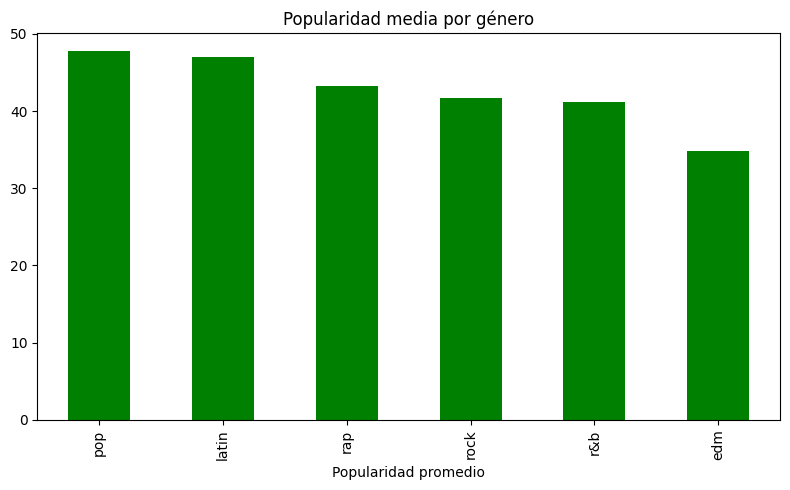

In [13]:
top_generos = data.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
top_generos.plot(kind='bar', color='green')
plt.title('Popularidad media por género')
plt.xlabel('Popularidad promedio')
plt.tight_layout()
plt.show()


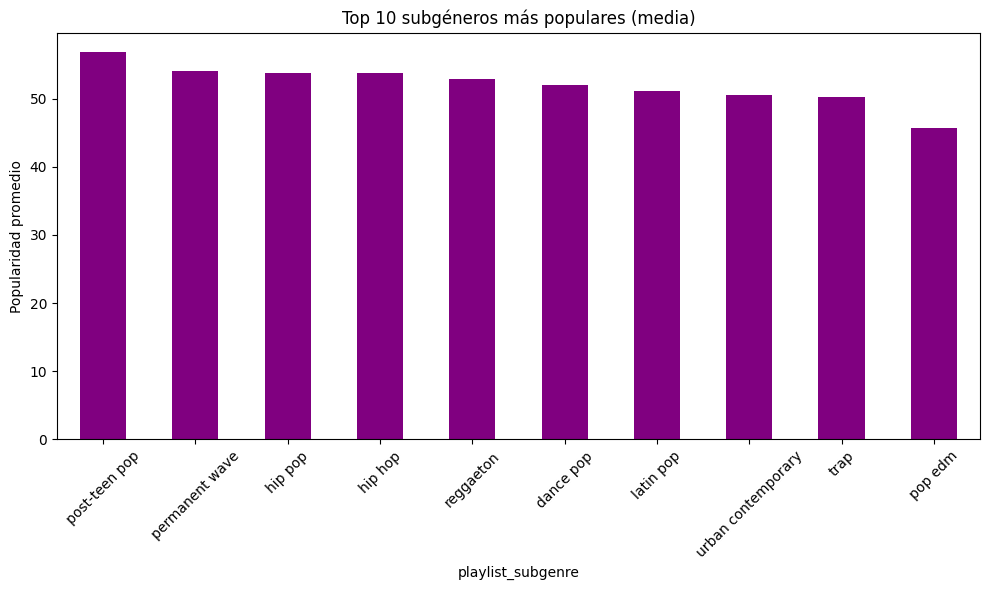

In [14]:
top_subgeneros = data.groupby('playlist_subgenre')['track_popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_subgeneros.plot(kind='bar', color='purple')
plt.title('Top 10 subgéneros más populares (media)')
plt.ylabel('Popularidad promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


De estos gráficos podemos extraer alguna información interesante. Por ejemplo, vemos como el género y subgénero más popular es pop y post-teen pop. Además, atendiendo al gráfico de popularidad de álbums, vemos como el dataset original tiene un error y muestra también el nombre de la canción. Este error no es muy relevante ya que se trata de una variable que no es relevante para clustering, por lo que será eliminada. A pesar de ello, en este gráfico podemos ver como las canciones más populares son Tusa y Dance Monkey, por lo que podemos intuir que los datos han sido extraídos en torno al año 2019.

## Preprocesado 

En esta sección llevamos a cabo el preprocesado del trabajo utilizando Spark. De forma resumida, en esta parte, realizamos las siguientes tareas: asignar los tipos correctos a las variables, filtrar algunos individuos para solucionar la existencia de individuos con valores corruptos, la eliminación de variables con un valor único para cada individuo (variables identificadoras del individuo), aplicación de one-hot encoding para permitir la inclusión de variables categóricas y la aplicación de reducción de dimensionalidad via PCA. 

### Carga de datos con PySpark

Una vez completado el análisis exploratorio de los datos con Pandas y herramientas de visualización convencionales, nos centramos en la problemática de Big Data inherente al proyecto. Para ello, comenzamos a trabajar con la tecnología Spark.

Empezaremos leyendo el conjunto de datos desde el archivo en formato **csv** que tenemos. Utilizando la función **read()** y algunas de sus funciones internas podemos especificar el formato de origen del archivo, si queremos que se incluya la cabecera o no (en nuestro caso, la incluiremos), el delimitador que existe en el archivo original para dividir los diferentes valores de un individuo (en nuestro caso, una coma), cargamos el archivo y con repartition indicamos a Spark, en la cantidad de particiones que queremos que distribuya los datos.


In [15]:
df = spark.read.format('csv') \
    .option('header', 'true') \
    .option('delimiter', ',') \
    .load('spotify_songs.csv') \
    .repartition(PARTS)

Mostramos los 10 primeros individuos del conjunto de datos. Observamos como la carga se ha completado, en principio, sin ningún problema aparente ni en los individuos ni en los atributos.

In [16]:
df.show(10, truncate=False) 

+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+------------------------+--------------------------------------------------+----------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|track_id              |track_name                            |track_artist         |track_popularity|track_album_id        |track_album_name                      |track_album_release_date|playlist_name                                     |playlist_id           |playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|
+----------------------+--------------------------------------+---------------------+----------------+----------------------+--------------------------------------+--------

Mostramos los nombres de los atributos y su tipo, imprimiendo el esquema del dataframe. Observamos como por defecto todos los atributos se cargan con tipo de dato **String***. Será necesaria más tarde una conversión de alguno de ellos a un tipo numérico. 

In [17]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: string (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- duration_ms: string (nullable = true)



A modo de comprobación, tras observar en el EDA los valores únicos de ciertas variables, comprobamos si se siguen cumpliendo tras la lectura de los datos en Spark.

In [18]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------------+
|      playlist_genre|
+--------------------+
|                 r&b|
|                 pop|
|                 edm|
|                 rap|
|                rock|
|               latin|
|1E5VdGGWkpDQ682gd...|
|4425cRh83Uzor4qCR...|
|5EMARioe9z9eKOeWI...|
|0JmBB9HfrzDiZoPVR...|
|48AzM7l4M02DBYd2N...|
| Matthias Heilbro...|
|6wyJ4bsjZaUKa9f6G...|
|37i9dQZF1DWTDafB3...|
+--------------------+

Número de géneros únicos: 14


Observamos como tenemos para la variable **playlist_genre** algunos valores inesperados, tras revisar el conjunto de datos observamos algunos individuos en el conjuntos de datos que tienen valores erróneos. En la siguiente sección, el preprocesado, lidiamos con este problema. 

Importamos algunas dependencias generales para el trabajo.

In [19]:
# Dependencias generales
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

### Asignación de los tipos correctos de las variables

Algunas variables como **track_popularity** (que mide la popularidad) y **danceability** (que mide cómo de bailable es una canción) entre muchas otras, tienen una naturaleza numérica.  Para ello, definimos una lista con los nombres de las columnas del DataFrame **df**, de las cuales queremos convertir su tipo.  A partir de aquí, realizamos un casting al tipo de dato DoubleType (números decimales) mediante un bucle.

In [20]:
# Lista de columnas a convertir
cols_to_convert = [
    "track_popularity", "danceability", "energy", "key", "loudness", "mode",
    "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
    "tempo", "duration_ms"
]

# Castea las columnas especificadas a DoubleType
for c in cols_to_convert:
    df = df.withColumn(c, col(c).cast(DoubleType()))

Observamos de nuevo el **esquema de DataFrame** donde ahora sí comprobamos que están las variables con su tipo correcto.

In [21]:
df.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_artist: string (nullable = true)
 |-- track_popularity: double (nullable = true)
 |-- track_album_id: string (nullable = true)
 |-- track_album_name: string (nullable = true)
 |-- track_album_release_date: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- playlist_id: string (nullable = true)
 |-- playlist_genre: string (nullable = true)
 |-- playlist_subgenre: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: double (nullable = true)



### Eliminación de instancias corruptas

Tras el análisis se han comprobado la existencia de ciertas instancias con valores corruptos en el conjunto de datos. Proponemos una solución directa, que en el contexto de Big Data y nuestro dataset (que tiene una suficiente cantidad de individuos) vemos viable y razonable: la eliminación directa. Para ello, se filtran únicamente las instancias que cumplen con alguno de los posibles valores de la variable categórica: playlist_genre (vista en el análisis). 

Utilizamos la construcción de una lista manual de los valores correctos y la función **filter()** para su correcto filtrado.

In [22]:
from pyspark.sql.functions import col

valid_genres = ['pop', 'rock', 'rap', 'edm', 'r&b', 'latin']
df = df.filter(col('playlist_genre').isin(valid_genres))

In [23]:
df.select('playlist_genre').distinct().show()
print("Número de géneros únicos:", df.select('playlist_genre').distinct().count())

+--------------+
|playlist_genre|
+--------------+
|           r&b|
|           pop|
|           edm|
|           rap|
|          rock|
|         latin|
+--------------+

Número de géneros únicos: 6


A modo de comprobación, mostramos y contamos los valores únicos de esa variable para comprobar que ya no existen los valores erróneos que obteníamos antes. Ahora sí, tenemos los verdaderos valores y su verdadera cantidad. Como no hemos detectado ningunos otros valores erróneos, asumimos que se han filtrado el resto de valores correctamente, y ya tenemos el conjunto de datos limpio.

### Eliminación de variables con valores únicos

Se eliminarán las variables que tienen un valor identificador para cada canción. Las variables como: track_id, track_name, track_artist, track_album_id, track_album_name, playlist_name y playlist_id son eliminadas en este apartado, porque actúan como identificadores únicos y no aportan valor predictivo ni patrones útiles al análisis; al tener un valor distinto para cada fila, no permiten generalización, pueden introducir ruido y aumentarían la complejidad del modelo sin beneficio real.

In [24]:
cols_to_drop = [
    'track_id', 'track_name', 'track_artist', 
    'track_album_id', 'track_album_name', 
    'playlist_name', 'playlist_id'
]

df = df.drop(*cols_to_drop)

### Inclusión de un ID propio

A pesar de haber eliminado las variables identificadoras como track_id o track_name, se incluirá una variable id (de construcción propia) que no será utilizada en el algoritmo de clustering, pero que servirá como referencia para realizar visualizaciones pertinentes. Esta variable nos permitirá vincular cada observación con sus valores originales de las variables categóricas playlist_genre y playlist_subgenre, facilitando así la interpretación y comparación de los resultados obtenidos por el clustering con las categorías iniciales de las playlists.

Para ello, utilizamos la función `monotonically_increasing_id`. Esta función genera valores enteros que aumentan de forma monótona, aunque no necesariamente consecutiva ni ordenada estrictamente, lo que garantiza unicidad sin necesidad de una columna de índice previamente definida. 

In [25]:
from pyspark.sql.functions import monotonically_increasing_id

# Añadimos la ID al comienzo de la línea
df = df.withColumn("id", monotonically_increasing_id())

 Mostramos la tabla resultante en la que podemos observar que ya no aparecen las variables eliminadas y aparece una columna con el atributo **id**.

In [26]:
df.show()

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|
|             0.0|              2013-09-20|           pop|       electropop|       0.723| 0.914|9.0|   -5.13| 0.0|     0.0409|      0.0862|           0.723|   0.231|  0.893|135.547|   220027.0|  1|
|         

### Aplicación de one-hot enconding a las variables categóricas

Para poder trabajar con las variables categóricas: **playlist_genre** y **playlist_subgenre**. E incluirlas dentro del algoritmo de agrupación, previamente debemos transformarlas de alguna forma su información a variables numéricas. Este tipo de variable categórica es no ordinal, no existe una relación de orden entre los valores o categorías. Por tanto, no podemos aplicar label enconding y optamos por aplicar one-hot encoding, utilizando la herramientas de Spark para ello. 
 
Se aplicará one-hot enconding a la variable: playlist_genre. La variable playlist_genre tiene (como se ha visto anteriormente) seis categorías diferentes. Por otro lado, la variable playlist_subgenre tiene 24 categorías, se optá por no incluir de ninguna forma esta variable ya aumentaría demasiado la dimensionalidad del conjunto de datos.

Spark utilizará una representación de Sparse Vector (vector disperso) para representar el one-hot enconding. Este vector diperso tiene tres componentes: la cantidad de elementos que se representan en el enconding, la posición activa en la codificación (la posición del 1 dentro del vector), y qué elemento se utiliza para representar (en nuestro caso, un 1.0).

Definimos una función llamada one_hot_preprocess, que dado el dataframe y una lista de las nombres de los atributos a convertir, devuelve el mismo dataframe añadiendo esas columnas transformadas a una representación de one-hot encoding.


In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def one_hot_preprocess(df, categorical_cols):

    indexers = [StringIndexer(inputCol=col, outputCol=col + '_idx', handleInvalid='keep') for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + '_idx', outputCol=col + '_ohe') for col in categorical_cols]

    pipeline = Pipeline(stages=indexers + encoders)
    return  pipeline.fit(df).transform(df)

In [28]:
# Copiar el DataFrame sin la varible 'playlist_genre'
# df_genre = df

In [29]:
categorical_cols = ['playlist_genre']
df = one_hot_preprocess(df, categorical_cols= categorical_cols)

Si observamos del dataframe la columna en **representación categórica** y la **transformada** podemos apreciar el tipo de representación que emplea Spark en los one-hot encodings. 

In [30]:
df.select('playlist_genre', 'playlist_genre_ohe').show(10, truncate=False)

+--------------+------------------+
|playlist_genre|playlist_genre_ohe|
+--------------+------------------+
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
|pop           |(6,[2],[1.0])     |
+--------------+------------------+
only showing top 10 rows



### Transformación del atributo de fecha de publicación

Por otro lado, de cara a utilizar la variable **track_album_release_date** optamos por no incluir la información completa de la fecha ya que una fecha tan exacta como el día o el mes no ofrecería una información excesivamente útil. Por otro lado, si optamos por incluir el año de publicación de la canción. Para ello, extraemos con Spark de la variable de la fecha original el año de publicación y lo incluimos en otro atributo.

In [31]:
from pyspark.sql.functions import substring

# Extraer el año de la fecha (formato 'YYYY-MM-DD')
df = df.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int")).cache()
# df_genre = df_genre.withColumn("release_year", substring("track_album_release_date", 1, 4).cast("int")).cache()

De forma intermedia, guardamos las variables del **id, playlist_genre y playlist_subgenre**. Ya que nos será útil para tras aplicar el agrupamiento, comparar el resultado del clustering con las categorías de las variables género y subgénero. Sobre todo esta última que no ha sido incluida dentro de las variables predictoras. 

Eliminamos; tras aplicar el one-hot enconding, descartar el uso del atributo del subgenero y reducir el uso de la fecha de publicación, estas tres variables para no crear redudancia y tener la menos dimensionalidad posible.

In [32]:
# Guardamos las variables 'playlist_genre' y 'playlist_subgenre' en otro dataframe
# Nota: serán útiles más tarde para comparar con los resultados del Clustering
df_var_saved = df.select('id', 'playlist_genre', 'playlist_subgenre')

print(df.show())

# Eliminación de variables transformadas y retiradas
df = df.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')
# df_genre = df_genre.drop('playlist_genre', 'playlist_subgenre', 'track_album_release_date')

+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|track_popularity|track_album_release_date|playlist_genre|playlist_subgenre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms| id|playlist_genre_idx|playlist_genre_ohe|release_year|
+----------------+------------------------+--------------+-----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------------+------------+
|            69.0|              2019-06-07|           rap|          hip hop|       0.951| 0.573|0.0|  -6.002| 0.0|      0.227|      0.0667|             0.0|   0.119|   0.42|105.052|   211040.0|  0|               1.0|     (6,[1],[1.0])|        2019|
|   

In [33]:
# Mostramos variables guardadas
df_var_saved.show(truncate=False)

+---+--------------+-----------------+
|id |playlist_genre|playlist_subgenre|
+---+--------------+-----------------+
|0  |rap           |hip hop          |
|1  |pop           |electropop       |
|2  |rock          |permanent wave   |
|3  |rock          |album rock       |
|4  |rock          |album rock       |
|5  |pop           |indie poptimism  |
|6  |pop           |post-teen pop    |
|7  |rock          |classic rock     |
|8  |rap           |hip hop          |
|9  |rap           |southern hip hop |
|10 |pop           |indie poptimism  |
|11 |pop           |dance pop        |
|12 |rap           |hip hop          |
|13 |rock          |album rock       |
|14 |rock          |album rock       |
|15 |pop           |electropop       |
|16 |pop           |indie poptimism  |
|17 |rap           |gangster rap     |
|18 |rock          |classic rock     |
|19 |pop           |indie poptimism  |
+---+--------------+-----------------+
only showing top 20 rows



Eliminamos el atributo intermedio generado por `StringIndexer` usado para la transformación a **one-hot enconding**. 

In [34]:
idx_cols = [col + '_idx' for col in categorical_cols]
df = df.drop(*idx_cols)

Mostramos finalmente como quedaría el dataset; tras limpiar o transformar atributos.

In [35]:
df.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|
+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+
|69.0            |0.951       |0.573 |0.0|-6.002  |0.0 |0.227      |0.0667      |0.0             |0.119   |0.42   |105.052|211040.0   |0  |(6,[1],[1.0])     |2019        |
|0.0             |0.723       |0.914 |9.0|-5.13   |0.0 |0.0409     |0.0862      |0.723           |0.231   |0.893  |135.547|220027.0   |1  |(6,[2],[1.0])     |2013        |
|0.0             |0.681       |0.893 |0.0|-3.519  |1.0 |0.037      |0.178       |0.0             |0.213   |0.815  |123.651|205132.0   |2  |(

### Preprocesado probado: Transformación de SparseVector a DenseVector

Al principio, al obtener `SparseVector` tras aplicar **one-hot encoding**, pensamos que debíamos convertirlos en columnas separadas ya que la implementación de **DBSCAN** que usamos requiere variables numéricas individuales, es decir, `DenseVector`. Sin embargo, pronto nos dimos cuenta de que esa transformación no era necesaria, ya que teníamos una alta dimensionalidad que obligaba por **limitación de recursos** a realizar una reducción de la dimensionalidad. Y que adicionalmente, tras estandarizar todas las variables volveríamos a `DenseVector`.

Spark maneja eficientemente los `SparseVector` y muchas de sus herramientas de Machine Learning de Spark, incluyendo su esta PCA, pueden trabajar directamente con ellos.

Por ello, tras aplicar estandarización y PCA, tendríamos el `DenseVector` que queríamos sin ser necesario este paso.

### Estandarización de los atributos

La **estandarización** es una técnica de preprocesamiento que transforma las variables para que tengan **media cero y desviación estándar uno**. Matemáticamente, cada valor $x$ de una variable se convierte en:

$$ z = \frac{x - \mu}{\sigma} $$

donde $ \mu $ es la **media** de la variable y $ \sigma $ su **desviación estándar**. Este proceso asegura que todas las variables contribuyan de manera equilibrada al análisis, especialmente en métodos sensibles a la escala como **PCA** o **clustering** que está basado en distancias.

Utilizamos `StandardScaler`de Spark para llevar a cabo esta transformación. Para ello, construimos una lista de nombres de columnas donde excluimos al atributo **ID**, ya que esta variable es simplemente identificadora. Utilizamos `VectorAssembler` para ensamblar todos los atributos en un `DenseVector` dentro de una única columna que llamamos **features**. (Esta es la forma de operar de Spark). 

Tras ello, se utiliza `StandardScaler` que tomando ese `DenseVector` ensamblado anteriormente, generará en otra columna llamada **scaled_features** otro `DenseVector` con las mismas dimensiones que contienen las características estandarizadas. De forma explícita, indicamos que utilice media cero y desviación uno con los parámetros `withMean` y `withStd`.  

Finalmente, por cuestiones de limpieza (y ligeramente, eficiencia) eliminamos la columna de los atributos ensamblados: **features**. 

In [36]:
columnas = df.columns

if "id" in columnas:
    columnas.remove("id")

In [37]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Ensamblar todas los atributos en un único vector dentro de una sola columna
assembler = VectorAssembler(inputCols=columnas, outputCol="features")
df = assembler.transform(df)

# Ajuste de la estandarización
scaler = StandardScaler(
    inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Eliminar la columna 'features'
df = df.drop('features')

df.show(20, truncate=False)

25/04/25 13:45:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|scaled_features                                                                                                                                                                                                                                                 

Observamos como obtenemos esa nueva columna con los atributos estandarizados `scaled_features` que tiene las dimensiones del DataFrame, sin contar el ID y ella misma, es decir, **20** valores. 

### Aplicación de reducción de la dimensionalidad

En el contexto de Big Data, el uso de PCA (Principal Component Analysis) es fundamental para reducir la dimensionalidad de grandes conjuntos de datos sin perder la mayor parte de la información relevante. Esto facilita el análisis, mejora el rendimiento de los algoritmos y reduce los costes computacionales. En **PySpark**, PCA se implementa de forma distribuida, lo que permite aplicar esta técnica de manera eficiente sobre datos masivos. Aprovechando el procesamiento paralelo de Spark para calcular los componentes principales sin comprometer escalabilidad ni velocidad.

Con su uso no solo mejoramos la eficiencia mediante la reducción de dimensionalidad, sino que de modo complementario ampliamos la riqueza de este preprocesamiento. 

#### Análisis de la varianza explicada de las componentes

De forma previa, debemos hacer un análisis de la varianza explicada de las componentes. En otras palabras, buscamos responder a la siguiente pregunta: ¿cuál es el mínimo número de componentes (dimensiones) que debemos tomar para explicar la mayor cantidad de información posible de los datos originales? 

Por supuesto, siempre que aplicamos PCA como una técnica de preprocesamiento debemos asegurarnos de tomar una cantidad de componentes principales suficiente para explicar un porcentaje lo suficientemente razonable de la varianza de los datos originales.

En este estudio buscamos analizar cómo se comporta la varianza explicada en función de las cantidad de componentes principales que tomamos. Para que después, podamos tomar la decisión activa de qué cantidad de componentes principales maximizan la varianza explicada y a su vez minimizan la dimensionalidad. 

Para ello, aplicamos `PCA` con una cantidad $k$ de componentes principales en su salida igual a las dimensiones originales de los datos. Posteriormente una vez obtenido el modelo ajustado `PCA` en su atributo `explainedVariance` tenemos la varianza explicada de cada componente. Visualizamos utilizando un diagrama de línea y otro de barras, no solo directamente la varianza explicada por componente, sino la varianza explicada acumulada.

In [38]:
from pyspark.ml.feature import PCA

# Obtener el tamaño del vector en la columna 'features'
vector_size = df.select("scaled_features").first()[0].size

pca = PCA(k = vector_size, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

25/04/25 13:45:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/25 13:45:32 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
25/04/25 13:45:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/04/25 13:45:32 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


[0.12425651 0.23617776 0.32277568 0.39915552 0.46728501 0.5270107
 0.58343955 0.63857329 0.68729757 0.73344538 0.77645893 0.81722258
 0.8578004  0.89051726 0.92105821 0.95006117 0.97077572 0.98966445
 1.         1.        ]


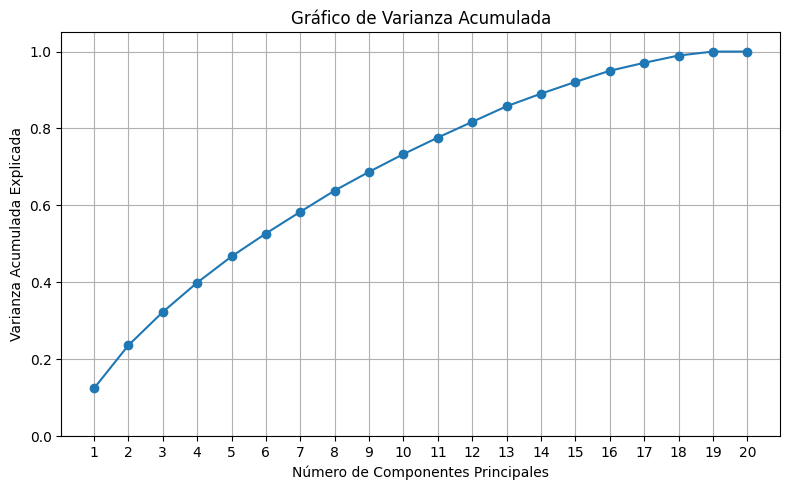

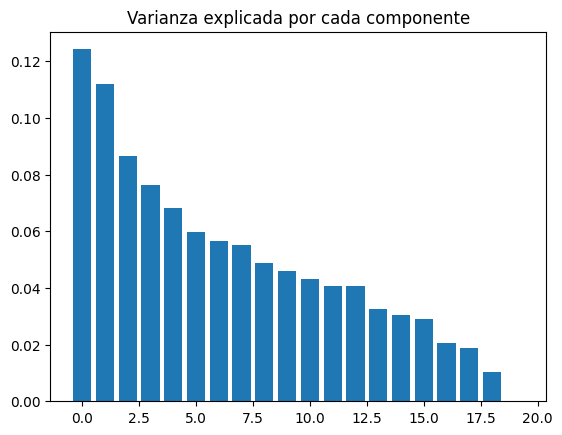

In [39]:
explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Gráfico de Varianza Acumulada')
plt.grid(True)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.tight_layout()
plt.show()

# Visualizar varianza explicada por cada componente
plt.bar(range(explained_variance.shape[0]), explained_variance/np.sum(explained_variance))
plt.title('Varianza explicada por cada componente')
plt.show()

Observamos en ambas gráficas, una tendencia bastante lineal y equidistante, sin un `elbow point` identificable. Por esta razón, optamos por tomar un valor de $k$ alto que asegure como mínimo un varianza explicada de $80 \%$. Sin embargo, queremos reducir de alguna forma significativa la dimensionalidad con esta técnica. Se optá por tomar `k = 14` ahorrando $6$ dimensiones extra, y obteniendo una varianza explicada acumulada total de $89,05 \%$.

#### Reducción de la dimensionalidad con PCA

Aplicamos la reducción con PCA a `DIMS = 14` Se crea el modelo indicando que la entrada será la columna de características estandarizadas (`scaled_features`) y la salida será `pca_features`. Luego, se ajusta el modelo a los datos con `fit()` y se transforma el DataFrame original, generando una nueva columna con las características reducidas. Finalmente, se elimina la columna original `scaled_features`, ya que la información relevante queda contenida en `pca_features`.


In [40]:
# Cantidad de componentes principales a conservar

# Ajustar el modelo de PCA
pca = PCA(k = DIMS, inputCol="scaled_features", outputCol="pca_features") 
pca_model = pca.fit(df)

# Transformar el dataframe
df = pca_model.transform(df)

# Eliminar la variable de 'scaled_features'
pca_data = df.drop('scaled_features')

In [41]:
pca_data.show(20, truncate=False)

+----------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+---+------------------+------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |duration_ms|id |playlist_genre_ohe|release_year|pca_features                                                                                                                                                                                                                                                                              |
+----------------+------------+------+---+--------+----+-----------+------------+---------

Observamos como la salida muestra un DataFrame enriquecido tras aplicar PCA, donde se mantienen las columnas originales como `track_popularity`, `danceability`, `energy`, etc., junto con variables adicionales como `playlist_genre_ohe` (resultado del one-hot encoding) y `release_year`. La nueva columna `pca_features` contiene un vector denso con los componentes principales obtenidos mediante PCA, que representan una versión comprimida de las características originales.


# Descripción de la solución propuesta

### Clustering con DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering basado en densidad. Su principal ventaja es la capacidad de identificar clústeres de forma arbitraria en datos con geometrías complejas y de detectar "ruido" o puntos aislados. En DBSCAN, un punto se clasifica como:
- **Punto núcleo (core point):** Si tiene al menos un número mínimo (`min_pts`) de puntos vecinos (dentro de un radio `epsilon`).
- **Punto frontera (border point):** Si es vecino de un punto núcleo, pero no cumple número mínimo de vecinos para ser núcleo.
- **Ruido:** Si no es vecino de un punto núcleo ni cumple el mínimo de vecinos.

La solución que se presenta adapta DBSCAN para entornos distribuidos utilizando Apache Spark, lo que permite el procesamiento en paralelo de grandes volúmenes de datos. 

### Descripción General de la Implementación en Spark

**Implementación de DBSCAN en Spark**  
Nuestro código del algoritmo DBSCAN en Spark está inspirado en la siguiente fuente: https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d/. La implementación ha sido modificada para ser más eficiente yse ha limpiado y documentado el código.

Dado que Spark está diseñado para el procesamiento distribuido de datos, el algoritmo se adapta de la siguiente manera:
1. **Particionado y Solapamiento:**  
Se asigna cada punto a particiones basadas en la distancia a un pivote seleccionado aleatoriamente. Alrededor de dicho pivote, se particionará el espacio en una hiperesfera central rodeada de hiperanillos. Para ello, se fija un parámetro `epsilon` que define el radio de estas particiones, de modo que un mayor valor de `epsilon` dará lugar a particiones más grandes y viceversa. 
Cada punto se incluye en dos particiones consecutivas, para capturar correctamente los puntos que se encuentran en los bordes y evitar que se pierda información sobre vecinos cercanos.

2. **Escaneo de Vecinos Local:**  
Dentro de cada partición, se identifican los vecinos de cada punto: se comparan todos los pares de puntos y se asigna un vecino si la distancia es menor que `epsilon`.

3. **Etiquetado Local de Clústeres:**  
Se asignan etiquetas a los puntos indicando el identificador de cluster y si es un punto núcleo. Para cada punto que sea un punto núcleo:
- Se le asigna una etiqueta con su ID como etiqueta de cluster y se indica que es un punto núcleo.
- A todos los vecinos del punto núcleo se le asigna una etiqueta con el ID del punto núcleo como etiqueta de cluster y se indica que no es un punto núcleo.

4. **Consolidación de Etiquetas y Componentes Conexas:**  
Se combinan las etiquetas locales. Dado que un mismo punto puede tener varias etiquetas, se "consolida" la información eligiendo una etiqueta específica o manteniendo todas las etiquetas si el punto es núcleo.
Se construye un grafo donde los vértices representan etiquetas (o clústeres locales) y se crean aristas entre etiquetas compartidas por el mismo punto.
Se aplica el algoritmo de componentes conexas sobre el grafo para unir clústeres locales y obtener un único identificador global para cada grupo de puntos conectados.



### Escalabilidad de la Solución

La solución implementada presenta varias decisiones de diseño que permiten escalar DBSCAN a grandes volúmenes de datos:

- **Procesamiento Distribuido en Spark:**  
  Aprovechando las transformaciones RDD (como `flatMap`, `reduceByKey` y `map`), el algoritmo procesa los datos en paralelo. Esto divide el trabajo en tareas más pequeñas y las distribuye a través de múltiples nodos, reduciendo el tiempo total de ejecución.

- **Particionado con Solapamiento:**  
  Al asignar cada punto a dos particiones consecutivas (usando una función de distancia respecto a un pivote), se garantiza que las comparaciones de vecinos se hagan en un conjunto reducido y localizado de datos, minimizando la necesidad de comunicaciones costosas entre nodos.

- **Uso de GraphFrames para Consolidación Global:**  
  La transformación local de etiquetas se “consolida” mediante la creación de un grafo donde se unen las etiquetas compartidas. GraphFrames, que está optimizado para el procesamiento de grafos en Spark, se encarga de ejecutar el algoritmo de componentes conexas de forma eficiente, integrando resultados locales en un clúster global.

- **Reducción de Operaciones de Cómputo:**  
  Con el uso de acumuladores y la agrupación previa de datos (por ejemplo, la unión de vecinos a través de `reduceByKey`), se minimiza el número de cálculos redundantes, lo que es clave al trabajar con grandes conjuntos de datos.

Estas decisiones permiten que, incluso para volúmenes masivos de datos, el algoritmo realice cálculos de distancia y verificación de vecindad de manera eficiente, aprovechando la computación distribuida.


In [42]:
def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance

In [48]:
from pyspark.sql.functions import col, floor, sqrt, collect_set
from pyspark.ml.functions import vector_to_array
from graphframes import GraphFrame
from itertools import combinations


def euclidean_distance_expr(vec1, vec2, dim):
    """
    Calcula la distancia euclidiana entre dos vectores en un espacio de dimensión dada.

    :param vec1: Lista o vector (tipo iterable) con coordenadas del primer punto.
    :param vec2: Lista o vector (tipo iterable) con coordenadas del segundo punto.
    :param dim: Entero que representa la cantidad de dimensiones a considerar para el cálculo.
    :return: Valor flotante correspondiente a la distancia euclidiana entre los dos vectores.
    """
    return sqrt(sum([(vec1[i] - vec2[i]) ** 2 for i in range(dim)]))

# Etiquetar núcleos y puntos base
def label_points(row, min_pts):
    """
    Función que etiqueta puntos como núcleos si supera un número minimo de vecinos. Los puntos base son 
    los vecinos de un punto núcleo

    :param min_pts: Número mínimo de puntos (incluyendo el mismo) para ser considerado punto núcleo.
    :return: Función que toma una tupla (id, vecinos) y retorna una lista de tuplas (id, [(etiqueta, es_núcleo)]).
    """
    id = row["src"]
    neighbors = row["neighbors"]
    if len(neighbors) + 1 >= min_pts:
        out = [(id, (id, True))]
        out.extend([(n, (id, False)) for n in neighbors])
        return out
    else:
        return []

# Combinar etiquetas por punto
def combine_labels(x):
    """
    Combina múltiples etiquetas de clúster para un punto y determina si es un punto núcleo.

    :param x: Tupla donde el primer elemento es el id del punto, y el segundo es una lista de (etiqueta, es_núcleo).
    :return: Tupla (id, etiquetas de clúster, es_núcleo) con todas las etiquetas si es núcleo, o solo una si no lo es.
    """
    point, tags = x
    core = any(tag[1] for tag in tags)
    clusters = [tag[0] for tag in tags]
    return point, clusters if core else [clusters[0]], core

def process_dataframe(spark, df, epsilon, min_pts, dim, checkpoint_dir):
    """
    Procesa un dataframe de entrada con el algoritmo DBSCAN
    :param spark: sesión de Spark
    :param df: dataframe de entrada donde cada fila tiene un id y valores 
    :param epsilon: parámetro de distancia de vecindad para DBSCAN
    :param min_pts: parámetro de mínimo de vecinos para DBSCAN
    :param dim: dimensiones de los datos de entrada
    :param checkpoint_dir: directorio requerido por Graphframe para almacenar datos
    :return: Un dataframe con el id de punto,su etiqueta de cluster y si es núcleo
    """
    # Convertimos el vector a array para poder acceder a los valores
    df = df.withColumn("value_array", vector_to_array(col("value")))

    # Seleccionamos un pivote aleatorio
    pivot_vector = df.select("value_array").limit(1).collect()[0][0]

    # Calcular la distancia al pivote 
    dist_expr = sum([
        (col("value_array")[i] - float(pivot_vector[i])) ** 2 for i in range(dim)
    ])
    # Calcular la
    df = df.withColumn("pivot_dist", sqrt(dist_expr)) 
    
    # Asignación de la partición original
    df_primary = df.withColumn("partition", floor(col("pivot_dist") / epsilon).cast("int"))

    # Replicar cada punto para asignarlo a la partición adyacente
    df_adjacent = df.withColumn("partition", (floor(col("pivot_dist") / epsilon) + 1).cast("int"))

    # Unir ambos DataFrames para que cada punto aparezca en ambas particiones
    df = df_primary.union(df_adjacent)

    # Alias para join consigo mismo
    df_a = df.alias("a")
    df_b = df.alias("b")

    # Join por partición y evitando duplicados (id_a < id_b)
    df_pairs = df_a.join(df_b, (col("a.partition") == col(
        "b.partition")) & (col("a.id") < col("b.id")))

    # Calcular distancia
    df_pairs = df_pairs.withColumn(
        "distance",
        euclidean_distance_expr(col("a.value_array"),
                                col("b.value_array"), dim)
    )
    # Filtrar vecinos
    df_neighbors = df_pairs.filter(col("distance") < epsilon) \
        .select(col("a.id").alias("src"), col("b.id").alias("dst"))

    # Agrupar vecinos por punto
    adjacency = df_neighbors.groupBy("src").agg(
        collect_set("dst").alias("neighbors"))

    # Etiquetar núcleos y puntos base
    labeled_rdd = adjacency.rdd.flatMap(lambda x: label_points(x, min_pts))

    # Combinar etiquetas
    combined = labeled_rdd.groupByKey().mapValues(list).map(combine_labels).cache()

    # Crear dataframe seleccionando una sola etiqueta de cluster
    df_initial = combined.map(lambda x: (x[0], x[1][0], x[2])) \
        .toDF(["point", "cluster_label", "core_point"])
    
    # Crear vértices y aristas
    vertices = combined.flatMap(
        lambda x: [(cid,) for cid in x[1]]).distinct().toDF(["id"])
    edges = combined.flatMap(lambda x: combinations(x[1], 2)) \
        .map(lambda x: (x[0], x[1])) \
        .distinct().toDF(["src", "dst"])

    # Crear grafo
    spark.sparkContext.setCheckpointDir(checkpoint_dir)
    g = GraphFrame(vertices, edges)
    components = g.connectedComponents()

    result = df_initial.join(components, df_initial.cluster_label == components.id) \
                       .select("point", "component", "core_point")

    return result

### Sampling de los datos

En el contexto del Big Data, donde los volúmenes de los datos son altos, el **sampling** - o muestreo de datos - se convierte en una herramienta fundamental para su análisis. Aunque puede parecer contradictorio reducir la cantidad de datos en un entorno dónde es especialmente útil su abundancia, nos ayudará a caracterizar la **escabilidad** de la implementación en función la cantidad de datos que usamos.

En esta parte se selecciona las columnas `id` y `pca_features` del DataFrame pca_data, luego se aplica un muestreo sin reemplazo usando una fracción definida por `FRAC` y una semilla fija para asegurar reproducibilidad. Posteriormente, la columna `pca_features` se renombra como value para unificar el nombre en etapas posteriores del procesamiento, y el resultado se almacena en caché para mejorar el rendimiento en futuras operaciones.

Visualizamos las primeras cinco filas del DataFrame.

In [49]:
df_pca = pca_data.select("id", "pca_features")
df_preproc = df_pca.sample(withReplacement=False, fraction=FRAC, seed=123456)

# Renombramos la columna por un nombre genérico como value
df_preproc = df_preproc.withColumnRenamed("pca_features", "value").cache()

# Mostrar el resultado
df_preproc.show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |value                                                                                                                                                                                                                                                                                  |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1  |[1.6615186744633719,-0.10257678442590903,0.31433482170705396,0.36837841717365544,-1.0206589025161696,0.7826920914497154,-0.36928324498551

25/04/25 13:46:55 WARN CacheManager: Asked to cache already cached data.


In [56]:
# Ejecución del algoritmo
EPSILON = 2
MINPTS = 20

df_clusters = process_dataframe(
            spark, df_preproc, EPSILON, MINPTS, 14, "checkpoints")

25/04/25 13:50:02 WARN BlockManager: Task 6410 already completed, not releasing lock for rdd_597_0


In [57]:
# Mostrar el resultado por cluster
df_counts = df_clusters.groupBy("component").count()
df_counts.show()

+---------+-----+
|component|count|
+---------+-----+
|       31| 1038|
|     1476|  967|
|       63|  945|
|     1484| 1175|
|        5|  814|
|       10| 1318|
|      247| 1200|
|       44|  878|
|        2| 1225|
|      233|  323|
|     1470|  893|
|     1467| 1310|
+---------+-----+



In [58]:
df_joined = df_preproc.join(
    df_clusters, df_preproc.id == df_clusters.point, how="left")
df_joined = df_joined.na.fill({'component': -1})
df_results = df_joined.select("id", "value", "component").toPandas()

print(df_results.head(10))

     id                                              value  component
0   964  [-0.1339994111228805, 0.18506497909921749, 0.5...         10
1  1677  [1.9710307895486525, 0.14743597196391747, 1.19...         -1
2  2214  [-0.7609312780961093, 1.6820030790613276, -1.0...         -1
3  2250  [2.9527387751856793, 0.4344431857116645, 1.392...       1484
4  2453  [2.7961701387136726, 0.627751607822127, 0.6870...       1484
5  2509  [2.3483940922082804, 0.425922715508965, 0.6758...       1484
6   541  [0.40754146475788966, 1.2516660630967453, -0.5...         -1
7   558  [-0.7107959131284323, 1.8672300370781496, -0.1...         63
8  1224  [-1.3313823151382422, -1.0986963075790768, 0.4...         -1
9  1258  [-0.9438886772907784, 2.377519149270206, -0.03...         31


Tras obtener los resultados de la aplicación del Clustering en el DataFrame `df_results`. Visualizamos los resultados proyectándolos en un espacio 2-dimensional. Para ello, utilizamos ambas opciones utilizar las dos componentes principales de la reducción previa que hemos aplicado via PCA y por otro lado, transformar los datos reducidos mediante otras técnicas de visualización (en concreto, usaremos `t-SNE`) a un espacio 2-dimensional.

El uso de `t-SNE` (t-distributed Stochastic Neighbor Embedding) se considera adecuado ya que preserva las relaciones locales entre los datos, es decir, mantiene cerca en el espacio proyectado a aquellos puntos que son similares en el espacio original de alta dimensión. Esto la convierte en una herramienta muy eficaz para observar agrupaciones o clusters de manera visual, ya que permite detectar patrones, separaciones y densidades que otras técnicas lineales como PCA podrían no mostrar con claridad. En un entorno donde ya se ha hecho un muestreo y una reducción previa (como con PCA), t-SNE ofrece una representación intuitiva en un espacio bidimensional que ayuda a validar si los datos presentan estructuras agrupadas de forma natural.


In [59]:
from sklearn.manifold import TSNE

X = np.array(df_results['value'].tolist())

# Obtenemos descompisición TSNE de 2 componentes para representar
tsne = TSNE(n_components=2, random_state=123456, n_jobs=-1)
X_tsne = tsne.fit_transform(X)

# Agregamos junto a PCA en el dataframe

df_results[['pca1', 'pca2']] = pd.DataFrame(
    df_results['value'].tolist(), index=df_results.index)[[0, 1]]
df_results['tsne1'] = X_tsne[:, 0]
df_results['tsne2'] = X_tsne[:, 1]
print(df_results.head(10))

     id                                              value  component  \
0   964  [-0.1339994111228805, 0.18506497909921749, 0.5...         10   
1  1677  [1.9710307895486525, 0.14743597196391747, 1.19...         -1   
2  2214  [-0.7609312780961093, 1.6820030790613276, -1.0...         -1   
3  2250  [2.9527387751856793, 0.4344431857116645, 1.392...       1484   
4  2453  [2.7961701387136726, 0.627751607822127, 0.6870...       1484   
5  2509  [2.3483940922082804, 0.425922715508965, 0.6758...       1484   
6   541  [0.40754146475788966, 1.2516660630967453, -0.5...         -1   
7   558  [-0.7107959131284323, 1.8672300370781496, -0.1...         63   
8  1224  [-1.3313823151382422, -1.0986963075790768, 0.4...         -1   
9  1258  [-0.9438886772907784, 2.377519149270206, -0.03...         31   

       pca1      pca2      tsne1      tsne2  
0 -0.133999  0.185065  42.336990  41.588634  
1  1.971031  0.147436  -7.183096  14.527082  
2 -0.760931  1.682003 -12.456601 -17.050632  
3  2.952739 

In [60]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_result(dataset, result_tags, file_name=None, style='ticks', title=""):

    # Preparamos los datos
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags

    # Ajustamos el formato
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    sns.scatterplot(x='x', y='y', data=df, ax=axes[0], color='blue')
    axes[0].set_title('Puntos sin etiquetar')

    # Añadimos los valores
    sns.scatterplot(x='x', y='y', data=df, hue='label',
                    ax=axes[1], palette='tab20')
    axes[1].set_title(title)

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    # Asignamos título
    if file_name:
        f.suptitle(title, fontsize=14)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Para que no se corte el gráfico
    plt.show()

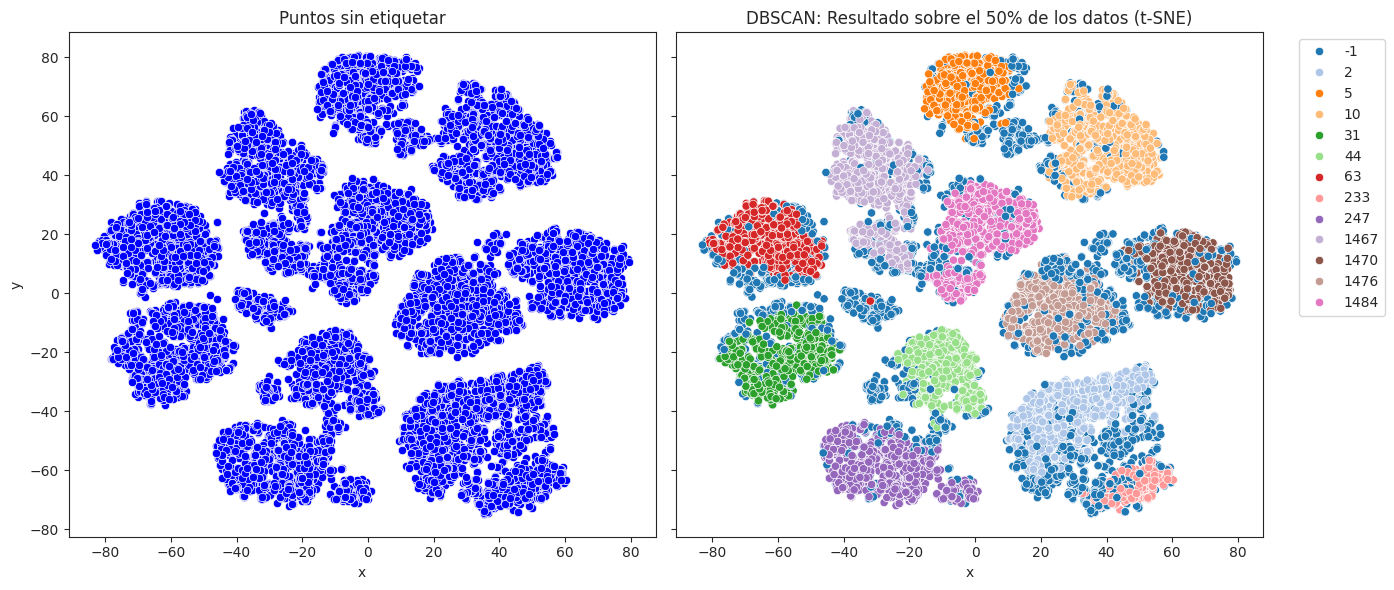

In [61]:
plot_result(X_tsne, df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (t-SNE)")

Observamos el resultado sobre el $50 \%$ de los datos visualizado con **t-SNE**: 
- Apreciamos como el espacio bidimensional proporcionado por **t-SNE** presenta claramente grupos separados. 
- Se encuentran $15$ clústeres que los representamos en diferentes colores, y un grupo adicional con etiqueta $-1$ que representa individuos outliers, es decir, individuos que no han sido agrupados a ningún clúster. 
- Se aprecia como los outliers en este espacio de los datos con una clara tendencia a ser clusteribles, se encuentran principalmente en los bordes de un clúster identificado. Y especialmente cerca del clúster identificado más cercano.

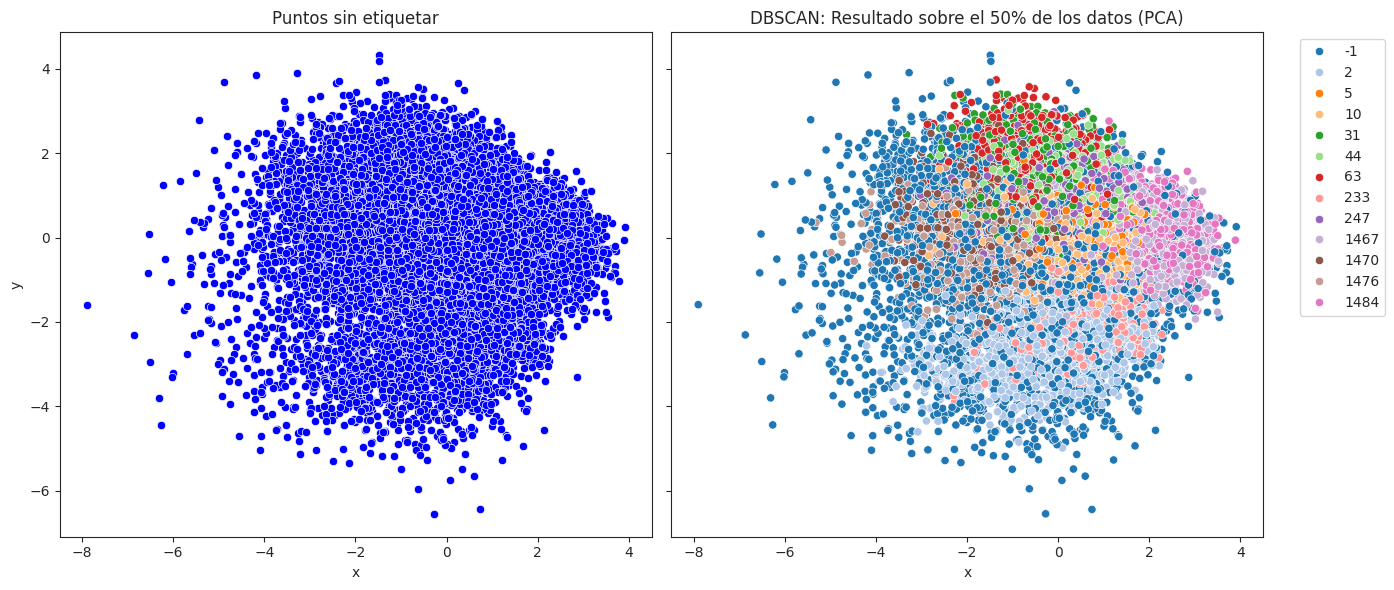

In [62]:
plot_result(df_results[['pca1', 'pca2']], df_results["component"], title="DBSCAN: Resultado sobre el 50% de los datos (PCA)")

In [63]:
df_subgeneros = df_var_saved.toPandas()
df_etiq_subgeneros = pd.merge(df_subgeneros, df_results, on='id')
print(df_etiq_subgeneros.head(5))

   id playlist_genre playlist_subgenre  \
0   1            pop        electropop   
1   2           rock    permanent wave   
2   3           rock        album rock   
3   4           rock        album rock   
4   5            pop   indie poptimism   

                                               value  component      pca1  \
0  [1.6615186744633719, -0.10257678442590903, 0.3...         -1  1.661519   
1  [1.0301788441414328, -1.6876705671596117, -1.5...          2  1.030179   
2  [-4.314419781541641, -2.5092536337125915, 1.06...         -1 -4.314420   
3  [-0.042713691477976615, -1.586806760538528, -1...          2 -0.042714   
4  [-0.6210886560872397, -0.1543577296194652, 0.4...          5 -0.621089   

       pca2      tsne1      tsne2  
0 -0.102577   9.273535  56.695755  
1 -1.687671  40.480133 -38.951275  
2 -2.509254  17.743034 -64.573051  
3 -1.586807  32.225506 -33.846897  
4 -0.154358   0.488615  70.692383  


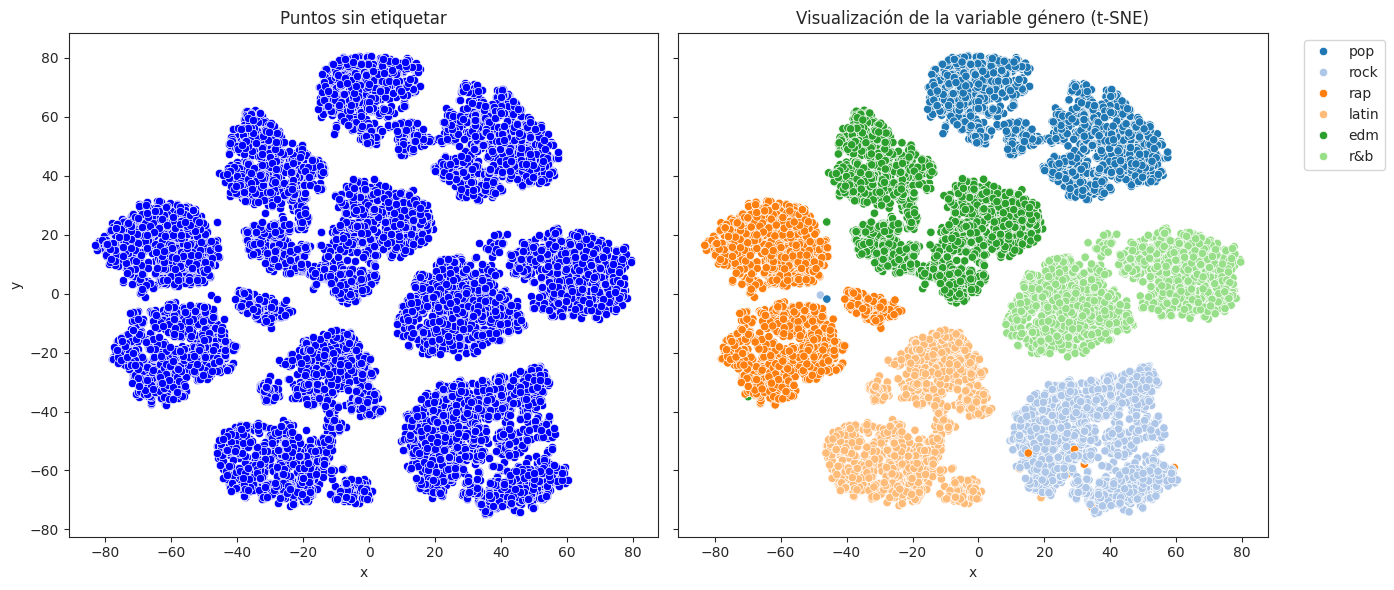

In [64]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_genre"], title="Visualización de la variable género (t-SNE)")

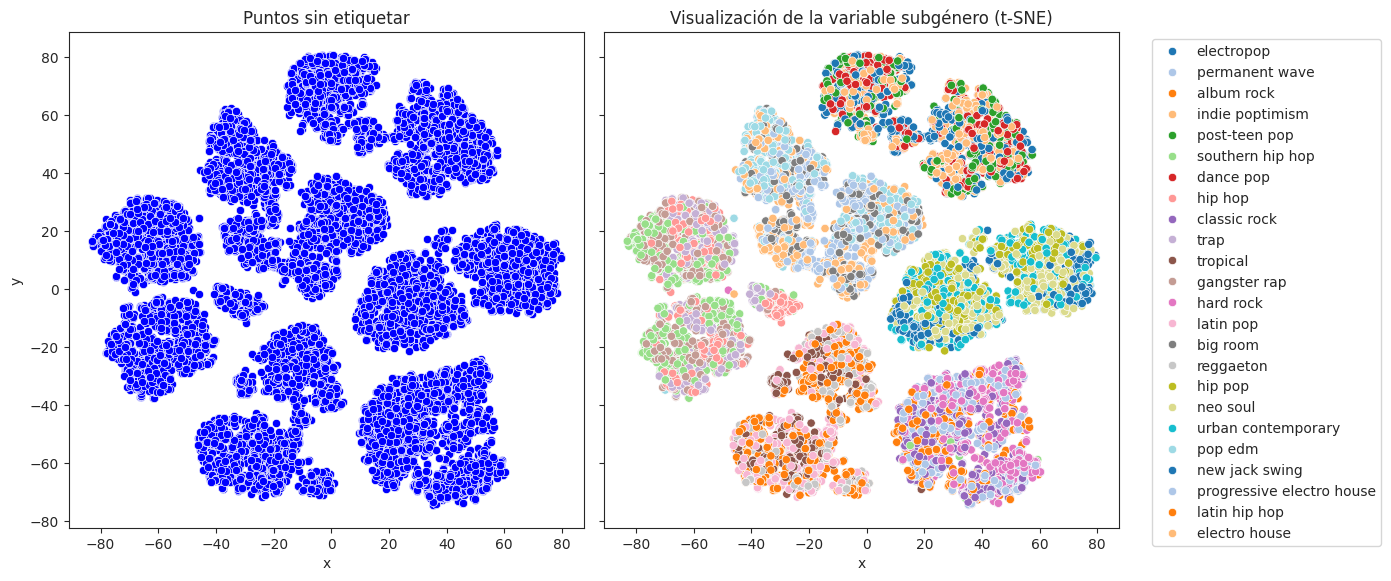

In [65]:
plot_result(df_etiq_subgeneros[['tsne1', 'tsne2']
                               ].values, df_etiq_subgeneros["playlist_subgenre"], title="Visualización de la variable subgénero (t-SNE)")

#### Métricas de calidad

Las métricas habitualmente empleadas en clustering,calculan medidas que tienen en cuenta la calidad de los clústeres, la distancia entre centroides, la cohesión de sus elementos, o bien, el grado de separación de los clústeres en el espacio. A esto se los conocen como medidas de calidad del clúster mediante métodos intrínsecos, y aunque no son fiables al 100%, combinando diferentes valores, podemos obtener un resultado relativamente fiable.

Existen multitud de métricas que podemos emplear. A continuación, describiremos las que hemos utilizado en nuestro problema.

##### <u>Davies-Bouldin</u>

El estadístico de calidad de clúster de Davies-Bouldin se centra en medir dos aspectos fundamentales:
- La dispersión de los valores dentro del clúster
- La separación entre los diferentes clústeres del espacio de búsqueda

En primer lugar, la dispersión viene dada por:

$$ Scatter_i = \frac{1}{n_i} \sum_{x \in C_i} d(x, c_i)$$

Donde n_i es el número de puntos de clúster i, $c_i$ es el centroide, y C, el conjunto total de puntos. La función d representa la distancia que escojamos, la cual, por razones de eficiencia, suele ser la distancia euclídea. Es decir, se calcula la distancia promedio de los valores al centro del clúster.

La seperación, por otro lado, viene dada por:

$$ Separation_{ij} = d(c_i, c_j) $$

Es decir, la distancia entre cada entre cada par de centroides.

Y el ratio de ambos nos permite obtener el resultado final:

$$DB= \frac{1}{N} \sum_{k=1}^N \frac{scatter_i + scatter_j}{separation_{ij}}$$

Por tanto, es preferible que su valor sea lo más pequeño posible, porque eso significa una menor dispersión dentro del cluster, y a su vez, una gran distancia entre los centroides.


##### <u>Silueta</u>

Silueta es otra medida comúnmente utilizada para estudiar la calidad de las agrupaciones, y al igual que Davis-Boulding, se suele acompañar de otras medidas para contrastar los resultados. Si bien, podría ser interesante poder obtener esta métrica para nuestros datos, debemos de tener cuidado con la eficiencia, ya que se calculan  una gran cantidad de distancias entre puntos que pueden requerir mucha memoria.

El algoritmo consiste en calcular la distancia entre una instancia de un clúster y el resto de instancias, para ver si el clúster está cohesionado y el valor se encuentra lejos del borde o no.

Su expresión viene dada por $S = \frac{1}{n} \sum_{i=1}^n s(i)$, donde:
- $a_i$: es la distancia promedio entre el punto i y el resto de valores de su clúster.
$$
a_i = \frac{1}{|C| - 1} \sum_{x \in C, x \neq i} d(i, x)
$$

- $b_i$: Es la distancia promedio entre el punto i y los puntos al clúster más cercano que al que no pertenece.

$$
b_i = \min_{C'} \frac{1}{|C'|} \sum_{x \in C'} d(i, x)
$$

Y por último, el índice s, que se calcula como una función a trozos dependiendo de si a es mayor a b, menor, o igual:

$$
s_i =
\begin{cases}
1 - \frac{a(i)}{b(i)} & \text{si } a(i) < b(i), \\[8pt]
\frac{b(i)}{a(i)} - 1 & \text{si } a(i) > b(i), \\[8pt]
0 & \text{si } a(i) = b(i).
\end{cases}
$$

Para la cantidad de puntos que disponemos, que en este caso es el 50% de los datos, es calculable, pero para mayores tamaños es posible que aparezcan problemas. Deberíamos, en tal caso, tratar de crear una implementación distribuida, pero para este caso, usaremos la implementación de SKLearn.

##### <u>Calinski-Harabasz (Pseudo F)</u>

Este índice permite conocer lo que se conoce como "ratio de varianza", es decir, el ratio entre la varianza dentro de cada clúster, y la varianza entre los diferentes cluster en el espacio. Esto hace que su definición sea bastante similar al índice de Davies-Bouldin, pero a diferencia de dicho calculo, su expresión es la siguiente:

$$S = \frac{BCCS/(k-1)}{WCSS/(n-k)}$$

Donde BCSS es la suma de cuadrados entre clústeres, representados a través de su centroide y el valor promedio de todos los centroides:
$$BCSS=\sum_{i=1}^{k}n_i||c_i-c||^2$$

Y WCSS permite medir cómo de compacto es un cluster, siendo muy similar al índice J de la función de coste minimizada por K-Means.

$$WCSS=\sum_{i=1}^{k} \sum_{x \in C_i}||x-c_i||^2$$

Y donde k es el número de clusters, $C_i$ hace referencia a un clúster, y $c_i$ a su centroide, mientras que c sin subíndice hace referencia al promedio de los centroides, es decir, una especie de supercentroide. Este método también es conocido como estadístico pseudo F, y se presenta para ser utilizado gracias a su efiencia computacional para ser calculado. Al emplear valores medios y centroides para realizar los cálculos, la dimensionalidad de los valores no implica el mismo impacto que el cálculo de distancias por pares como el caso de Silueta, y por tanto, podemos estimarlo con todos los datos adecuadamente.  Queremos que los clústers sean lo más cohesionados posibles, y que además, estén muy separados entre sí. Por tanto, queremos obtener el valor más alto posible.

Esta métrica es una buena alternativa para contrastar los resultados y evaluar el rendimiento del modelo que queremos crear.

In [66]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

valores_puntos = [np.array(vec.values) for vec in df_results["value"]]

print("-------- Métricas para clustering --------")
print("Pseudo F: ", calinski_harabasz_score(
    valores_puntos, np.array(df_results["component"])))
print("Davies-Bouldin: ", davies_bouldin_score(valores_puntos,
      np.array(df_results["component"])))
print("Silueta: ", silhouette_score(valores_puntos,
      np.array(df_results["component"])))

-------- Métricas para clustering --------
Pseudo F:  792.9485281278368
Davies-Bouldin:  2.400083324674529
Silueta:  0.029629655198298133


# Discusión de resultados

Está claro que, al haber incluido la variable genres dentro de PCA, los clusteres se han visto influenciados en buena medida por los géneros de cada canción. Sin embargo, los subgéneros no se incluyeron, lo cual nos da lugar a realizar un análisis por género sobre cómo se distribuyen sus subgéneros.

Resulta curioso cómo la mayoría de los clusteres de cada género musical se divide en dos (según los resultados de DBCSCAN). Sin embargo, dichas distinciones no son por subgénero, como podemos ver comparando las respectivas gráficas.

La única agrupación que se sale de la norma de representar la mitad de un género es el cluster 2, el cual junta a dos de las mitades de distintos géneros: rap y rock. Parece ser que hay cierta conexión entre estos géneros. Además, en el gráfico con la representación de t-SNE y coloreado por género se puede apreciar cómo hay algunos puntos dentro del cúmulo de canciones rock etiquetados como rap. Esto puede haber tendido un puente entre ambos géneros, lo cual explicaría la creación de este clúster.

También se detecta un número considerable de outliers, los cuales pueden representar canciones con ciertos aspectos que las diferencian lo suficiente de las demás como para no pertenecer a ningún cluster.

En cuanto a métricas...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fa435b-89c8-4b22-a4df-60f2ff3508a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>